In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.lines as mlines

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os
import corner

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

# Colors
from palettable.colorbrewer.qualitative import Dark2_7
from palettable.colorbrewer.qualitative import Set1_7
from palettable.tableau import Tableau_10
col = Dark2_7.hex_colors
col2 = Tableau_10.hex_colors
col = Set1_7.hex_colors

from palettable.cubehelix import cubehelix3_16
cubehelix = cubehelix3_16.hex_colors

import seaborn as sns

# Lya peak and EW after going through the IGM

Max: how are observed EW and peak velocity changed by the IGM?

## Load tables and Mh

In [2]:
tabs = sorted(reionizer.insensitive_glob(os.environ['LYA_DATA_DIR']+'data/withMh_FaintGals_Tot_Tau_lists/Z*'))
print('Loaded',len(tabs),'tables')

xHI_tab = np.array([float(t.split('nf')[-1]) for t in tabs])

# Get halo masses
tab   = pd.read_csv(tabs[0], sep='\t', skiprows=(1,1))
tab   = tab.drop(tab.index[[0]])
logMh_all = np.log10((tab['Mass']))
logMh = np.unique(logMh_all)

print(logMh)

tab_header = open(tabs[0])   
header = tab_header.readline()
line   = header.strip().split()
tab_header.close()
los_deltaV = np.array([-float(v) for v in line[4:]])

Loaded 40 tables
[10.24610177 10.37027987 10.49445794 10.61863604 10.74281418 10.86699221
 10.99117032 11.11534852 11.23952645 11.36370466 11.48788283 11.61206084
 11.73623885 11.86041695 11.98459504]


## Make input EW and DV for all halos

### Make Muv, with scatter

19999
75


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


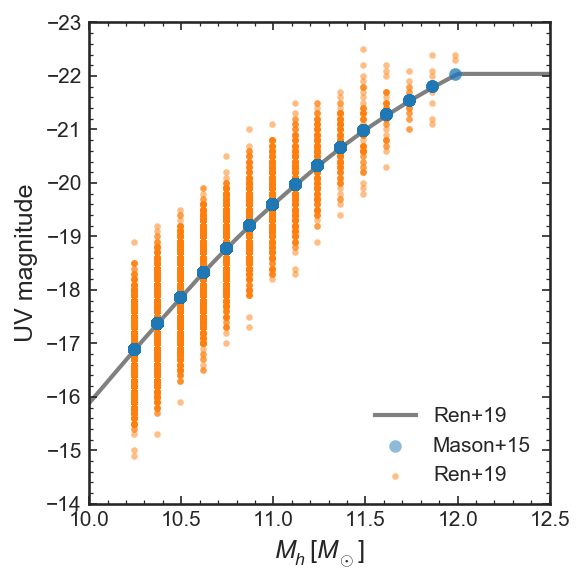

In [3]:
# Without scatter
Muv = reionizer.Mason15_MuvMh(np.log10(tab['Mass']), z=6.8)

# With scatter ================
sigma = 0.2*2.5
Muv_crit  = np.genfromtxt(os.environ['LYA_DATA_DIR']+'data/Muv_vs_Mh/CharlotteLvMz70Sigma20.txt')
logMh_R19 = Muv_crit[:,0]
Muv_R19   = Muv_crit[:,1]

Muv_crit_interp = np.interp(logMh, logMh_R19, Muv_R19)

# Add Muv scatter to sim halos
Muv_crit_sim = np.interp(logMh_all, logMh_R19, Muv_R19)
Muv_scatter  = np.random.normal(loc=Muv_crit_sim, scale=sigma)
print(np.unique(Muv_scatter).size)
Muv_scatter  = np.round(Muv_scatter, 1)
print(np.unique(Muv_scatter).size)

#===============================

# Plot
plt.figure(figsize=(4,4), dpi=150)

plt.plot(logMh_R19, Muv_R19, c='0.5', label='Ren+19', zorder=0)
# plt.plot(logMh, Muv_crit_interp)
plt.scatter(logMh_all, Muv, alpha=0.5, rasterized=True, label='Mason+15')
plt.scatter(logMh_all, Muv_scatter, alpha=0.5, s=10, rasterized=True, label='Ren+19', zorder=0)

plt.gca().invert_yaxis()
plt.xlim(10, 12.5)
plt.ylim(-14, -23)

plt.legend()

plt.xlabel('$M_h \, [M_\odot]$')
plt.ylabel('UV magnitude')
plt.tight_layout()

### Make EW

In [4]:
W_tab = np.arange(0., 1000., 0.001)

def draw_EW_Muv(Muv, size=10):
    
    # Make p(EW | Muv)
    cdf_WintrMuv = reionizer.CDF_exp(Muv, W=W_tab)

    # Sample from it
    return reionizer.sample_from_cdf(cdf_WintrMuv, x=W_tab, Ndraw=size, pmin=0., pmax=1., dx=0.001)
    
# Without scatter

##### Check order is right
EW_in = []
for M in np.unique(Muv):
    size = len(Muv[np.abs(Muv - M) < 0.01])
    EW_in.append(draw_EW_Muv(M, size=size))
EW_in = np.array([item for sublist in EW_in for item in sublist])

# With scatter
EW_in_scatter = []
for M in np.unique(Muv_scatter):
    size = len(Muv_scatter[np.abs(Muv_scatter - M) < 0.01])
    EW_in_scatter.append(draw_EW_Muv(M, size=size))
EW_in_scatter = np.array([item for sublist in EW_in_scatter for item in sublist])

EW_in20 = []
for M in np.unique(Muv):
    size = len(Muv[np.abs(Muv - M) < 0.01])
    EW_in20.append(draw_EW_Muv(-20., size=size))
EW_in20 = np.array([item for sublist in EW_in20 for item in sublist])

Text(0, 0.5, 'EW [A]')

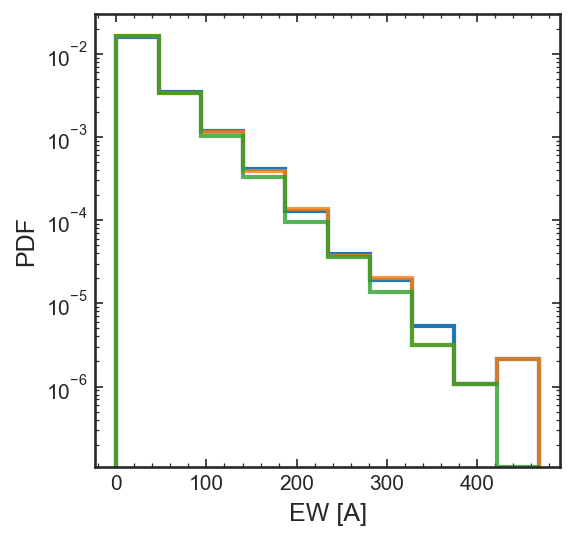

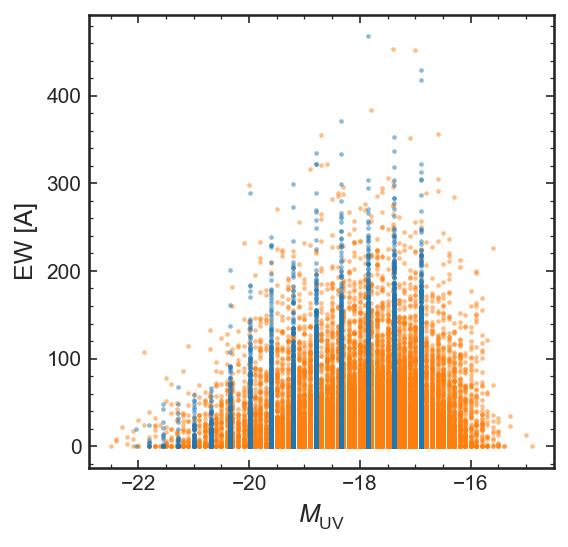

In [5]:
plt.figure(figsize=(4,4), dpi=150)
n, bins, patches = plt.hist(EW_in, histtype='step', lw=2, log=True, density=True, zorder=1)
plt.hist(EW_in_scatter, bins=bins, histtype='step', lw=2, alpha=0.8, log=True, density=True)
plt.hist(EW_in20, bins=bins, histtype='step', lw=2, alpha=0.8, log=True, density=True)
plt.xlabel('EW [A]')
plt.ylabel('PDF')

plt.figure(figsize=(4,4), dpi=150)
plt.scatter(Muv, EW_in, alpha=0.5, s=5, rasterized=True)
plt.scatter(Muv_scatter, EW_in_scatter, alpha=0.5, s=5, rasterized=True, zorder=0)

plt.xlabel(r'$M_\mathrm{UV}$')
plt.ylabel('EW [A]')

### Make DV

19999


/home/cmason/Documents/Research/LyaInference/LyaInference/reionizer/utils.py:441: RuntimeWarning: divide by zero encountered in log10
  V = m_v * (log_Mh[:,None] - b_v) + c_v - np.log10(DV)[None,:]
/home/cmason/Documents/Research/LyaInference/LyaInference/reionizer/utils.py:444: RuntimeWarning: divide by zero encountered in true_divide
  pdf_DV = np.exp(- 0.5 * (V / sigma_v) ** 2.) / denom
/home/cmason/Documents/Research/LyaInference/LyaInference/reionizer/utils.py:444: RuntimeWarning: invalid value encountered in true_divide
  pdf_DV = np.exp(- 0.5 * (V / sigma_v) ** 2.) / denom


Text(0, 0.5, '$\\Delta v$ km/s')

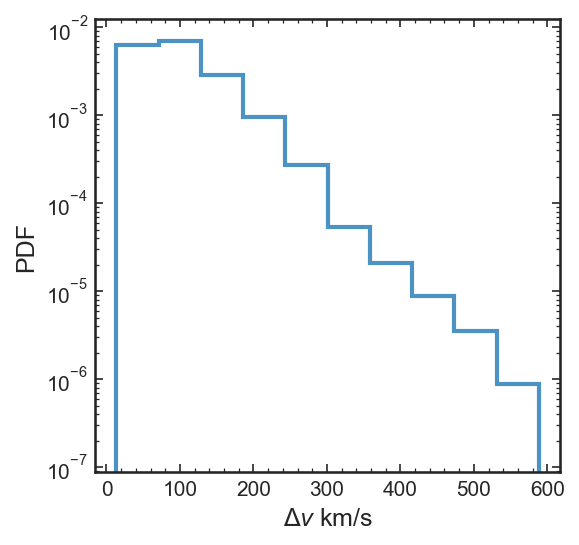

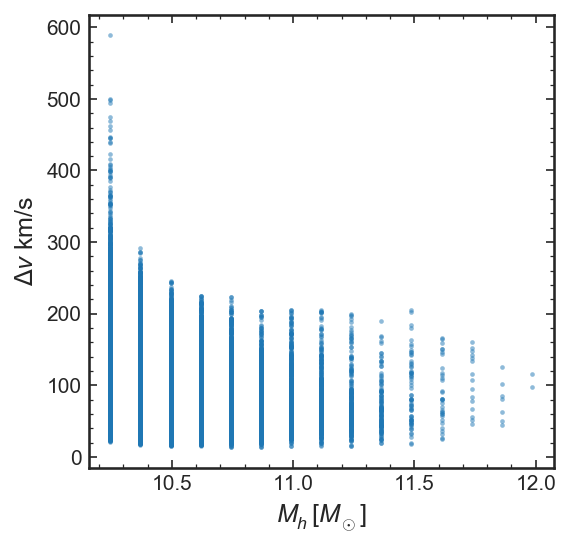

In [6]:
DV_samples = np.zeros(len(tab))
DV_tab     = np.linspace(0., 2000., 1000)

# Only calculate for unique Mh values
pdf_DV_Mh = reionizer.p_DV_logMh(logMh, DV=DV_tab)

# Will always complain integral != because there is a tail to high DV
DV_in = []
for mm, logm in enumerate(logMh):
    size = len(logMh_all[np.abs(logMh_all - logm) < 0.1])
    DV_in.append(reionizer.sample_from_pdf(pdf_DV_Mh[mm], x=DV_tab, Ndraw=size, pmin=0.001, pmax=0.97))

DV_in = np.array([item for sublist in DV_in for item in sublist])
print(len(np.unique(DV_in)))
# DV_in  = np.round(DV_in, 1)
# print(np.unique(DV_in).size)

plt.figure(figsize=(4,4), dpi=150)
plt.hist(DV_in, histtype='step', lw=2, alpha=0.8, log=True, density=True)
plt.xlabel('$\Delta v$ km/s')
plt.ylabel('PDF')

plt.figure(figsize=(4,4), dpi=150)
plt.scatter(logMh_all, DV_in, alpha=0.5, s=5, rasterized=True)
plt.xlabel('$M_h \, [M_\odot]$')
plt.ylabel('$\Delta v$ km/s')

# Load optical depth and calculate transmissions

In [7]:
def load_opticaldepth(table, logMh, vmax=3000.):
    """
    Load optical depths as a function of Mh in a given simulation table
    :param table:
    :param Mh:
    :return:
    """
    # Only integrate from DV = 0 as blueward emission
    # all resonantly absorbed
    # TODO extend to Vcirc?
    vlim       = np.where(los_deltaV >= 0.)
    los_DV_red = los_deltaV[vlim]

    # Extend integrals to high v --> what should max optical depth be?
    vextend       = np.linspace(max(los_deltaV) + 10, vmax)
    los_DV_extend = np.concatenate((los_DV_red, vextend))

    # Load table for given Mh
    mass_taus = table.iloc[np.where(np.abs(np.log10(table['Mass']) - logMh) < 0.01)[0]]
    exp_taus  = np.exp(-mass_taus.iloc[:, 1:])
    optdepth  = exp_taus.iloc[:, vlim[0]]

    # Extend integrals to high v, linearly extrapolate optical depth
    m = np.median(np.gradient(optdepth.iloc[:,-5:], axis=1)/np.gradient(los_DV_red[-5:]), axis=1)
    c = optdepth.iloc[:,-1]- m*los_DV_red[-1]

    optdepth_extend = m[:,None]*vextend + c[:,None]
    optdepth_extend[optdepth_extend > 1.] = 1.

    optdepth = np.concatenate((optdepth, optdepth_extend), axis=1)

    return optdepth, los_DV_extend

In [8]:
DV_tab_long = np.arange(0., 3000., 5.)

def get_transmission(xHI, EW_cut=5., Muv_cut=-16., vpeak_cut=0., 
                     fixed_dv_foroptdepth=200., vmin_cgm=None, EW20=False):
    
    xHI = reionizer.find_nearest(xHI, xHI_tab)

    tab_path = reionizer.insensitive_glob(os.environ['LYA_DATA_DIR']+'data/withMh_FaintGals_Tot_Tau_lists/Z*nf%.2f' % xHI)
    
    assert len(tab_path) > 0, "no optical depth table found"

    # Get halo masses
    tab   = pd.read_csv(tab_path[0], sep='\t', skiprows=(1,1))
    tab   = tab.drop(tab.index[[0]])
    
    vpeak_out = np.zeros(len(tab))
    EW_out    = np.zeros(len(tab))
    optdepth_fixed_dv = np.zeros(len(tab))
    
    for logmh in logMh:
        if vmin_cgm is None:
            vmin = reionizer.vcirc(logmh, z=7.)
        else:
            vmin = vmin_cgm
        
        optdepth, los_DV_extend = load_opticaldepth(tab, logmh)
        
        logMh_match = np.where(np.abs(np.log10(tab['Mass']) - logmh) < 0.01)[0]
   
        trans     = np.zeros(len(logMh_match))
        vpeak_mh  = trans.copy()
        optdepth_fixed_dv_mh = trans.copy()
        
        for vv, DV in enumerate(DV_in[logMh_match]):
            fwhm = 50 + DV # Verhamme+17 in prep

            J_in  = reionizer.line_shape_gauss(DV_tab_long, DV, vmin=vmin, fwhm=fwhm)

            optdepth_interp = np.interp(DV_tab_long, los_DV_extend, optdepth[vv])
            J_out = J_in * optdepth_interp

            vpeak_mh[vv] = DV_tab_long[np.argmax(J_out)]
            trans[vv]    = np.trapz(y=J_out, x=DV_tab_long)
            optdepth_fixed_dv_mh[vv] = optdepth_interp[np.abs(DV_tab_long - fixed_dv_foroptdepth) < 1.]
        
#         if vv % 50 == 0:
#             ln = plt.plot(DV_tab_long, reionizer.line_shape_gauss(DV_tab_long, DV, vmin=0., fwhm=fwhm), ls='dashed', lw=1, alpha=0.8)
#             plt.plot(DV_tab_long, J_out, lw=1, alpha=0.8, c=ln[0].get_color())
#     plt.xlim(-50., 500)
           
#     plt.plot(DV_tab_long, DV_tab_long, c='0.5', lw=1)
#     plt.scatter(DV_in[logMh_match], vpeak_out, s=10, alpha=0.5, label=xHI)
        
        vpeak_out[logMh_match] = vpeak_mh 
        if EW20:
            EW_out[logMh_match]    = EW_in[logMh_match]*trans
        else:
            EW_out[logMh_match]    = EW_in20[logMh_match]*trans
            
        optdepth_fixed_dv[logMh_match] = optdepth_fixed_dv_mh
    
#     plt.scatter(EW_out[EW_out > 5.], vpeak_out[EW_out > 5.], s=1, color=plt.cm.viridis(xHI), alpha=0.5, rasterized=True)
#     sns.jointplot(EW_out[EW_out > 5.], vpeak_out[EW_out > 5.], color=plt.cm.viridis(xHI), kind="kde", kde_kws={'shade':False})
    
    if EW20:
        trans_all = EW_out/EW_in
    else:
        trans_all = EW_out/EW_in20
    
    cut = np.where((EW_out > EW_cut) & (Muv_scatter < Muv_cut) & (vpeak_out > vpeak_cut))

    data = {'optdepth':optdepth_fixed_dv[cut], 
            'trans':trans_all[cut], 
            'Muv':Muv_scatter[cut],
            'EW_in':EW_in[cut],
            'EW_out':EW_out[cut],
            'vpeak':vpeak_out[cut],
            'DV_in':DV_in[cut],
            }

    del tab
    
    return data


def get_transmission_only(xHI, ):
    
    xHI = reionizer.find_nearest(xHI, xHI_tab)

    tab_path = reionizer.insensitive_glob(os.environ['LYA_DATA_DIR']+'data/withMh_FaintGals_Tot_Tau_lists/Z*nf%.2f' % xHI)
    
    assert len(tab_path) > 0, "no optical depth table found"

    # Get halo masses
    tab   = pd.read_csv(tab_path[0], sep='\t', skiprows=(1,1))
    tab   = tab.drop(tab.index[[0]])
    
    trans_all = np.zeros(len(tab))
    
    for logmh in logMh:
        
        vmin = reionizer.vcirc(logmh, z=7.)
        
        optdepth, los_DV_extend = load_opticaldepth(tab, logmh)
        
        logMh_match = np.where(np.abs(np.log10(tab['Mass']) - logmh) < 0.01)[0]
   
        trans     = np.zeros(len(logMh_match))
        vpeak_mh  = trans.copy()
        optdepth_fixed_dv_mh = trans.copy()
        
        for vv, DV in enumerate(DV_in[logMh_match]):
            fwhm = 50 + DV # Verhamme+17 in prep

            J_in  = reionizer.line_shape_gauss(DV_tab_long, DV, vmin=vmin, fwhm=fwhm)

            optdepth_interp = np.interp(DV_tab_long, los_DV_extend, optdepth[vv])
            J_out = J_in * optdepth_interp

            trans[vv]    = np.trapz(y=J_out, x=DV_tab_long)
        
        trans_all[logMh_match] = trans 

    del tab
    
    return trans_all

In [9]:
def fix_corner_axes(ax, vmin, vmax):
    for i in range(ax.shape[0]):
        # xaxes
        for j in range(ax.shape[1]):
            ax[i,j].set_xlim(vmin[j], vmax[j])
        
        if i > 0:        
            ax[i,0].set_ylim(vmin[i], vmax[i])
        if i > 1:
            ax[i,1].set_ylim(vmin[i], vmax[i])
        
        ax[i,i].set_yticklabels(ax[i,i].get_yticks())
        ax[i,i].yaxis.set_major_formatter(plt.LogFormatterMathtext())    
        ax[i,i].yaxis.tick_right()
    return

## High DV make transmission higher

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corner/corner.py:294: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, 1.1 * np.max(n))
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corner/corner.py:294: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, 1.1 * np.max(n))
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corner/corner.py:294: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, 1.1 * np.max(n))
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corner/corner.py:294: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, 1.1 * np.max(n))
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corn

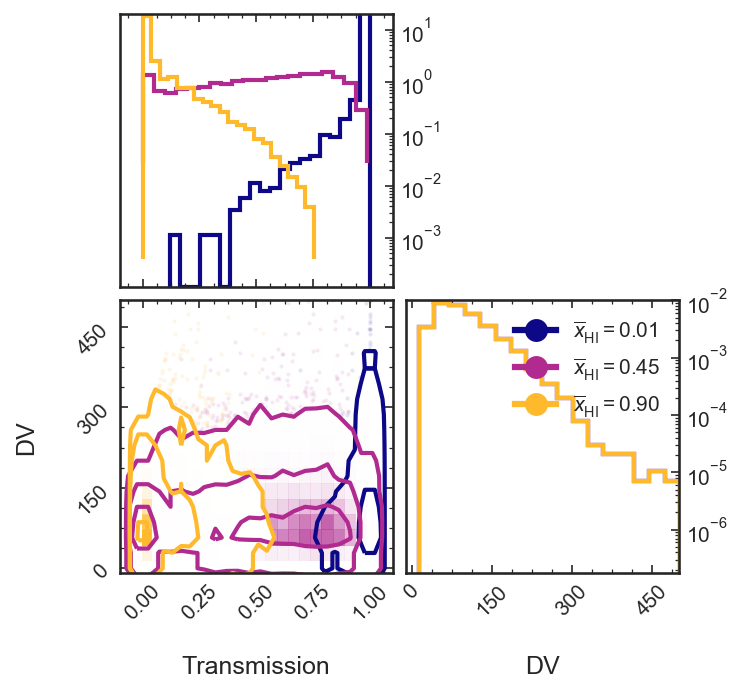

In [25]:
fig, ax = plt.subplots(2,2, figsize=(5,5), dpi=150)

handles = []
for xHI in xHI_pick:
    T = get_transmission_only(xHI)
    color = plt.cm.plasma(xHI-0.05)
#     plt.scatter(T, DV_in, alpha=0.1, s=5, c=color)
    
    corner.corner(np.vstack((T, DV_in)).T, fig=fig, 
                      color=color, 
                      labels=['Transmission', 'DV'],
#                       smooth=1,
                    levels=1.0 - np.exp(-0.5 * np.arange(1., 3.1, 1.) ** 2),

                      title_kwargs={"fontsize": 12}, 
                      hist_kwargs={'lw':2, 'log':True, 'density':True},
#                       plot_datapoints=False,
#                       hist2D_kwargs={'log':True},  
                      )
    
    handles.append(mlines.Line2D([], [], color=color, marker='o', lw=3, markersize=10, 
                                     label=r'$\overline{x}_\mathrm{HI} = %.2f$' % xHI))
    
plt.legend(handles=handles)
fix_corner_axes(ax, [-0.1, -10.], [1.1, 500])

## Plot distributions at fixed xHI

### Plot _observed_ distributions of EW, vpeak and optical depth

At high xHI (>0.9):
 - DV increases in **all galaxies** (distorted by high damping wings)
 - For **observable** LAEs, only see galaxies from high optical depth sightlines if their vpeak is high

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corner/corner.py:292: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-0.1 * maxn, 1.1 * maxn)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corner/corner.py:292: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-0.1 * maxn, 1.1 * maxn)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corner/corner.py:292: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-0.1 * maxn

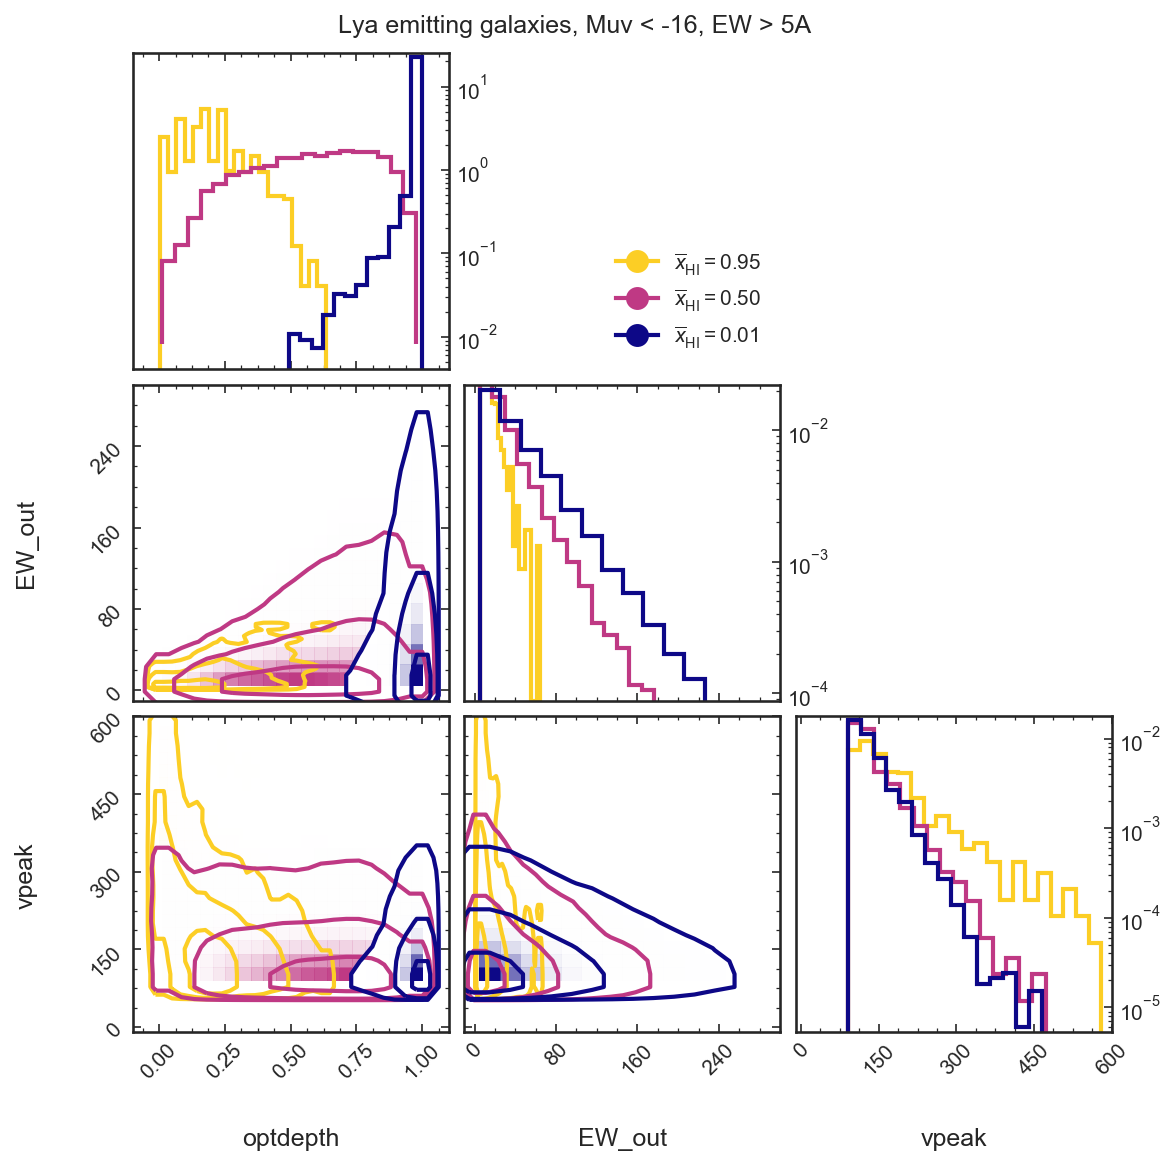

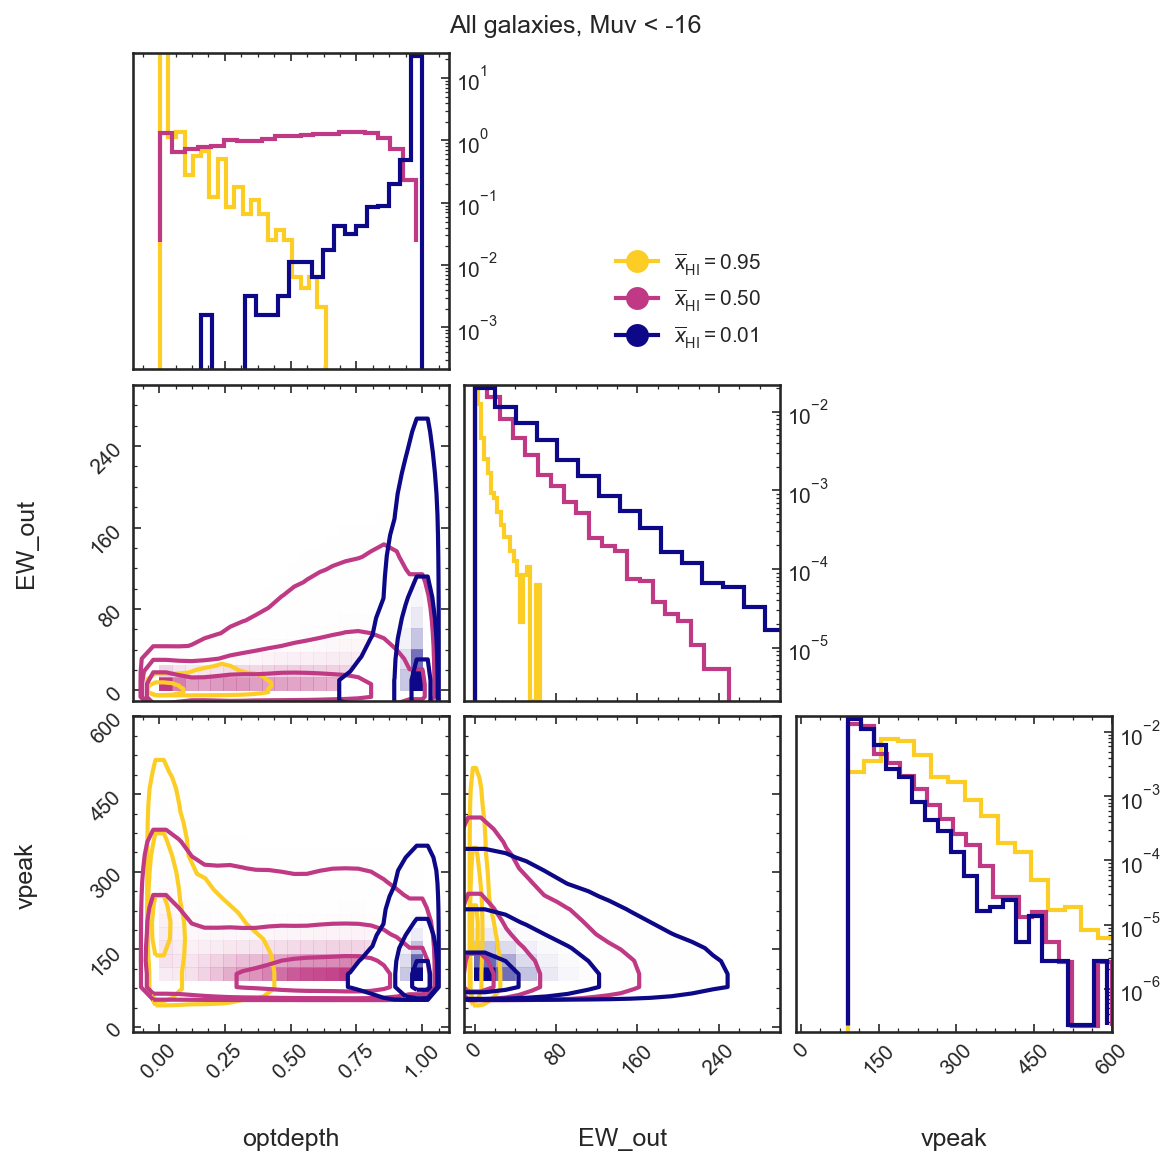

In [21]:
logMh_pick = 11.36
xHI_pick   = [0.01, 0.50, 0.95]

labels = np.array([
                  'optdepth',
#                   'DV_in',
                  'EW_out',
#     'EW_in', 
                  'vpeak'])


titles = ['Lya emitting galaxies, Muv < -16, EW > 5A',
          'All galaxies, Muv < -16']
plotnames = ['p_EW_vpeak_xHI_LAEs.png', 'p_EW_vpeak_xHI_allgals.png']
EW_cut_tab = [5., 0.]

for i, EW_cut in enumerate(EW_cut_tab):
    
    handles = []

    fig, ax = plt.subplots(len(labels), len(labels), figsize=(8,8), dpi=150)
    
    plt.suptitle(titles[i])
    
    for xHI in xHI_pick[::-1]:
    
        data = get_transmission(xHI=xHI, EW_cut=EW_cut, Muv_cut=-16.)
        
        color = plt.cm.plasma(xHI-0.05)
            
        # Plot it    
        data_to_plot = np.array([data[l] for l in labels]).T
    #     print(data_to_plot)

        corner.corner(data_to_plot, fig=fig, 
                      labels=labels,
                      #quantiles=[0.16, 0.5, 0.84], 
                      color=color, 
                      scale_hist=True,
                      smooth=1,
                      levels=1.0 - np.exp(-0.5 * np.arange(1., 3.1, 1.) ** 2),
                      #show_titles=True,
                      title_kwargs={"fontsize": 12}, 
                      hist_kwargs={'lw':2, 'log':True, 'density':True},
                      plot_datapoints=False,
                      hist2D_kwargs={'log':False},  
                      )

        handles.append(mlines.Line2D([], [], color=color, marker='o', markersize=10, 
                                     label=r'$\overline{x}_\mathrm{HI} = %.2f$' % xHI))

        del data, data_to_plot

    ax[0,1].legend(handles=handles, loc='lower right')

    vmin = [-0.1, -10., -10.]
    vmax = [1.1, 300., 600.]

    fix_corner_axes(ax, vmin, vmax)
            
    fig.savefig(plotnames[i], bbox_inches='tight')

### Look at p(EW, vpeak | xHI) for some vpeak cuts

Expect low probability of high EW for low vpeak

In [16]:
np.arange(1., 3.1, 1.)

array([1., 2., 3.])

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corner/corner.py:292: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-0.1 * maxn, 1.1 * maxn)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corner/corner.py:292: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-0.1 * maxn, 1.1 * maxn)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/corner/corner.py:292: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-0.1 * maxn

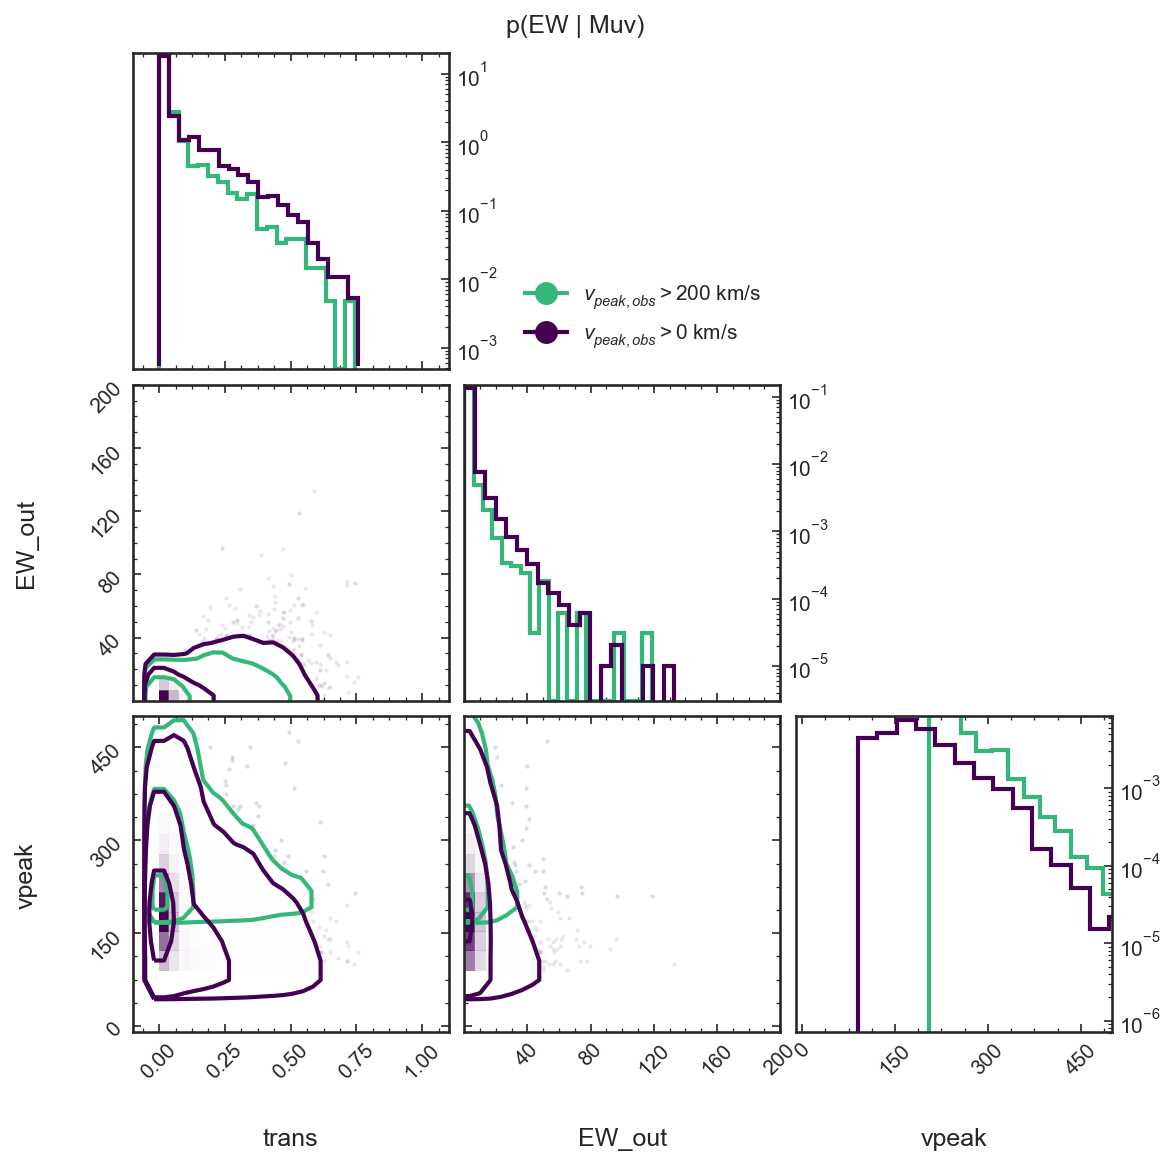

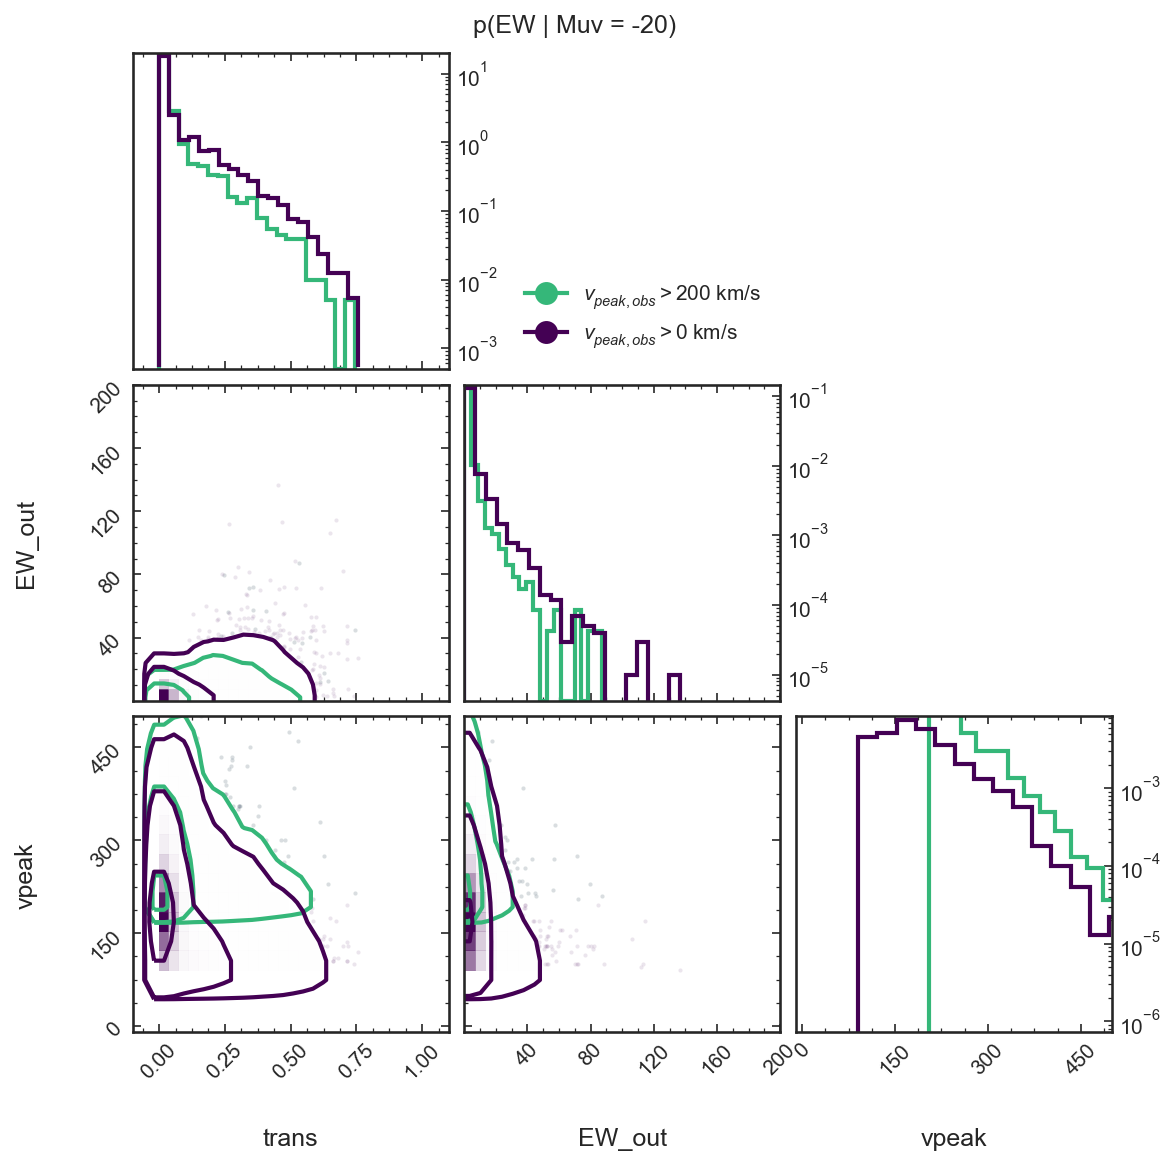

In [24]:
logMh_pick = 11.36
xHI_pick   = [0.01, 0.45, 0.9]

handles = []
labels  = np.array([
                'trans',
#               r'Transmission',
#               r"$M_\mathrm{UV}$",
#               r"emitted EW [A]", 
#             'EW_in',
              'EW_out', 
              'vpeak'])

titles = ['p(EW | Muv)',
          'p(EW | Muv = -20)']
# plotnames = ['p_EW_vpeak_xHI_LAEs.png', 'p_EW_vpeak_xHI_allgals.png']

EW_20_tab = [False, True]

for i, EW_20 in enumerate(EW_20_tab):
    
    handles = []
    
    fig, ax = plt.subplots(len(labels), len(labels), figsize=(8,8), dpi=150)
    plt.suptitle(titles[i])      

    vpeak_cut_tab = [200., 0.]
    for vpeak_cut in vpeak_cut_tab:

        data = get_transmission(xHI=0.9, EW_cut=0., EW20=EW_20, 
                                vpeak_cut=vpeak_cut)

        color = plt.cm.viridis(vpeak_cut/300.)

        # Plot it    
        data_to_plot = np.array([data[l] for l in labels]).T

        corner.corner(data_to_plot, fig=fig, 
                      labels=labels,
                      #quantiles=[0.16, 0.5, 0.84], 
                      color=color, 
                      scale_hist=True,
                      smooth=1,
                      levels=1.0 - np.exp(-0.5 * np.arange(1., 3.1, 1.) ** 2),
                      #show_titles=True,
                      title_kwargs={"fontsize": 12}, 
                      hist_kwargs={'lw':2, 'log':True, 'density':True},
                      plot_datapoints=True,
                      hist2D_kwargs={'log':False},  
                      )

        handles.append(mlines.Line2D([], [], color=color, marker='o', markersize=10,
                                     label=r'$v_{peak,obs} > %.0f$ km/s' % vpeak_cut))

    ax[0,1].legend(handles=handles, loc='lower right')

    vmin = [-0.1,  1e-10, -10.]
    vmax = [1.1, 200., 500.]

    # ax[2,1].set_xscale('log')
    # ax[1,1].set_xscale('log')

    fix_corner_axes(ax, vmin, vmax)
            
# # fig.savefig('p_EW_DV_xHI.pdf', bbox_inches='tight')

## Make table with all the params

In [42]:
xHI_all      = []
vpeak_all    = []
EW_all       = []
optdepth_all = []
trans_all    = []
DV_in_all    = []

for xx, xHI in enumerate(xHI_tab[::5]):
    
    print('xHI = %.2f' % xHI)
    
    data = get_transmission(xHI=xHI, EW_cut=0.)
        
    vpeak_all.append(data['vpeak'])
    xHI_all.append(np.tile(xHI, len(data['vpeak']))) 
    EW_all.append(data['EW_out'])
    optdepth_all.append(data['optdepth'])
    trans_all.append(data['trans'])
    DV_in_all.append(data['DV_in'])
    
xHI_all      = np.array([item for sublist in xHI_all for item in sublist])
vpeak_all    = np.array([item for sublist in vpeak_all for item in sublist])
EW_all       = np.array([item for sublist in EW_all for item in sublist])
optdepth_all = np.array([item for sublist in optdepth_all for item in sublist])
trans_all    = np.array([item for sublist in trans_all for item in sublist])
DV_in_all    = np.array([item for sublist in DV_in_all for item in sublist])

vpeak_df = pd.DataFrame(dict(xHI=xHI_all, vpeak=vpeak_all, EW_out=EW_all, optdepth=optdepth_all, trans=trans_all, DV_in=DV_in_all))

xHI = 0.01


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


xHI = 0.12
xHI = 0.29
xHI = 0.45
xHI = 0.61
xHI = 0.74
xHI = 0.84
xHI = 0.91


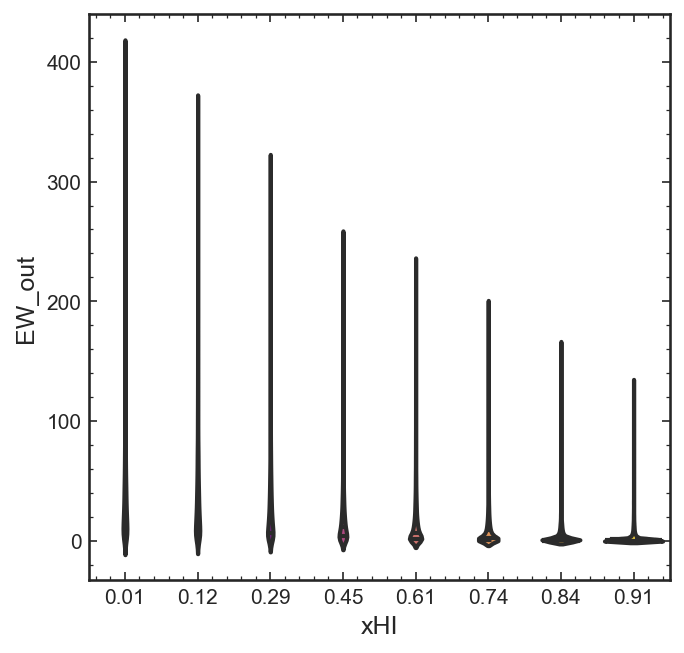

In [37]:
plt.figure(figsize=(5,5), dpi=150)
sns.violinplot(x="xHI", y="EW_out", data=vpeak_df, inner="quartile", palette=plt.cm.plasma(xHI_tab[::5]))
plt.savefig('EW_pdf_evolution.pdf', bbox_inches='tight')

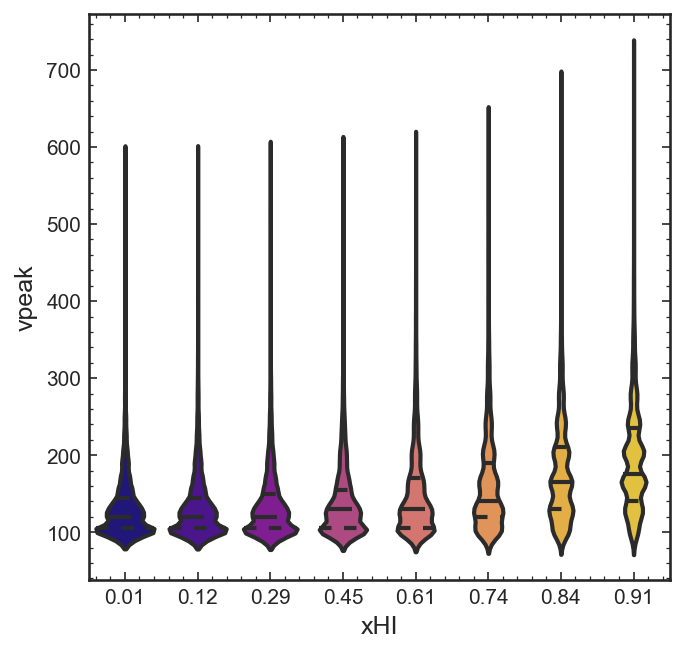

In [38]:
plt.figure(figsize=(5,5), dpi=150)
sns.violinplot(x="xHI", y="vpeak", data=vpeak_df, inner="quartile", palette=plt.cm.plasma(xHI_tab[::5]))
plt.savefig('vpeak_pdf_evolution.pdf', bbox_inches='tight')

Text(0, 0.5, 'v_peak')

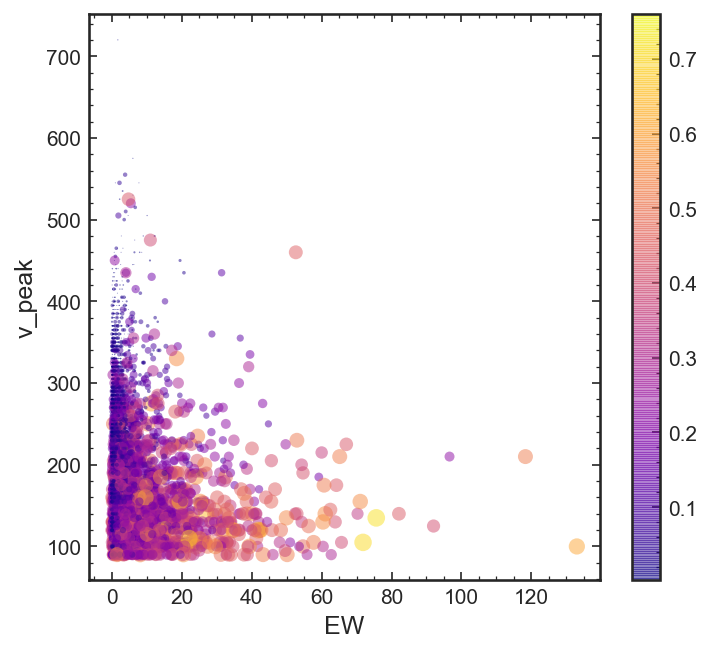

In [43]:
plt.figure(figsize=(5.5,5), dpi=150)

vpeak_df_highxHI = vpeak_df[vpeak_df.xHI > 0.9]

plt.scatter(vpeak_df_highxHI['EW_out'], vpeak_df_highxHI['vpeak'], 
            c=vpeak_df_highxHI['optdepth'], cmap=plt.cm.plasma, 
            s=100*vpeak_df_highxHI['optdepth'], 
            alpha=0.5)

plt.colorbar()
plt.xlabel('EW')
plt.ylabel('v_peak')

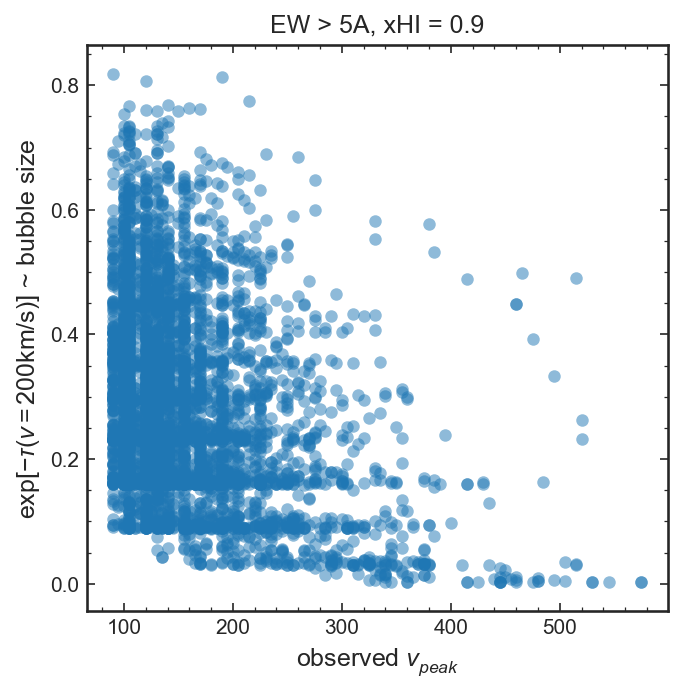

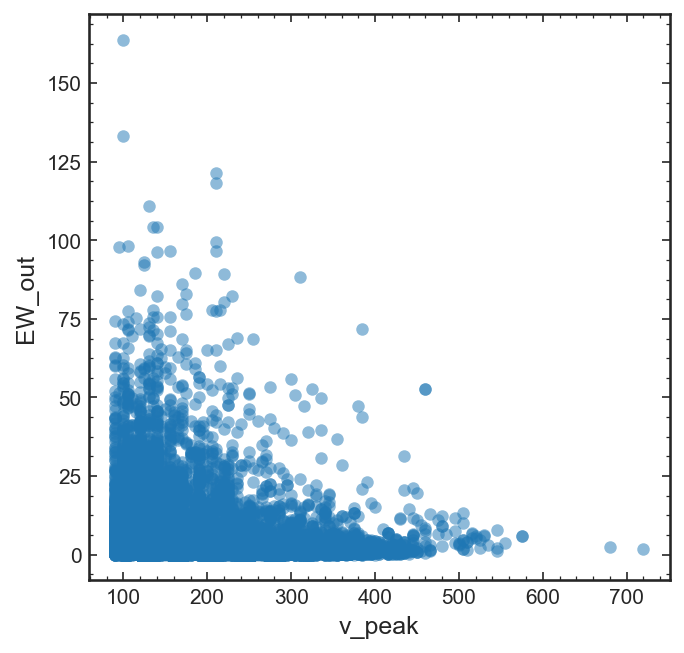

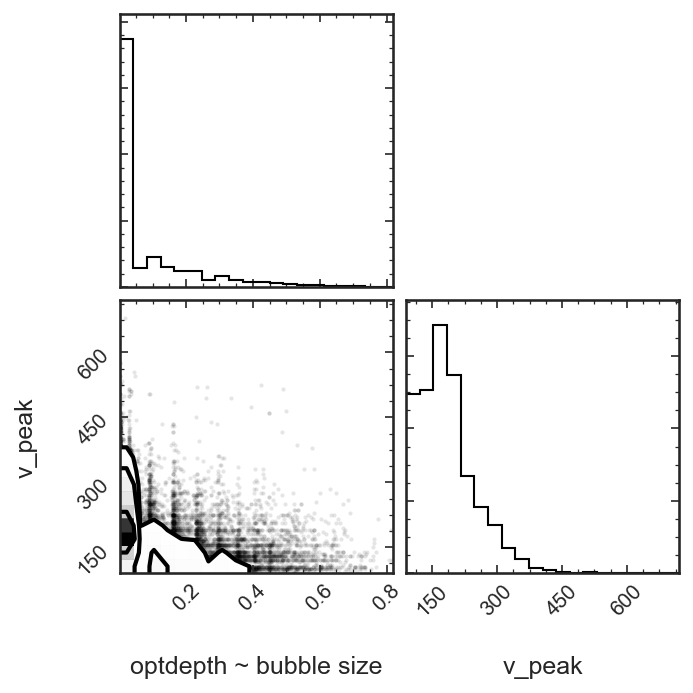

In [63]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)

vpeak_df_highxHI_hightEW = vpeak_df_highxHI[vpeak_df_highxHI.EW_out > 5.]

plt.scatter(vpeak_df_highxHI_hightEW['vpeak'], vpeak_df_highxHI_hightEW['optdepth'], alpha=0.5)
# plt.scatter(vpeak_df_highxHI_hightEW['vpeak'], vpeak_df_highxHI_hightEW['trans'], alpha=0.5)
plt.title('EW > 5A, xHI = 0.9')
plt.xlabel('observed $v_{peak}$')
plt.ylabel(r'$\exp[{-\tau(v=200\mathrm{km/s})}]$ ~ bubble size')
plt.savefig('vpeak_vs_optdepth.pdf')

fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
plt.scatter(vpeak_df_highxHI['vpeak'], vpeak_df_highxHI['EW_out'], alpha=0.5)
# plt.scatter(vpeak_df_highxHI['vpeak'], vpeak_df_highxHI['trans'], alpha=0.5)
# plt.scatter(vpeak_df_highxHI['vpeak'], vpeak_df_highxHI['optdepth'], alpha=0.5)
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-3, 1)

plt.xlabel('v_peak')
plt.ylabel('EW_out')

fig, ax = plt.subplots(2,2, figsize=(5,5), dpi=150)
# sns.kdeplot(vpeak_df_highxHI['optdepth'], vpeak_df_highxHI['vpeak'])
vpeak_df_highxHI = vpeak_df[vpeak_df.xHI > 0.8]
f= corner.corner(np.vstack((vpeak_df_highxHI['optdepth'], vpeak_df_highxHI['vpeak'])).T, 
              labels=['v_peak', 'optdepth ~ bubble size'][::-1],
              hist_kwargs={'lw':1}, hist2d_kwargs={'log':True}, fig=fig)



17.238650266065623 134.35640047175374 0.9150878325587937 0.001434741058296829 3.10130275345689
-35.71823144860025 46.716289541413104 -0.9996047316726052 1.543431290485704e-10 0.4101135368940759


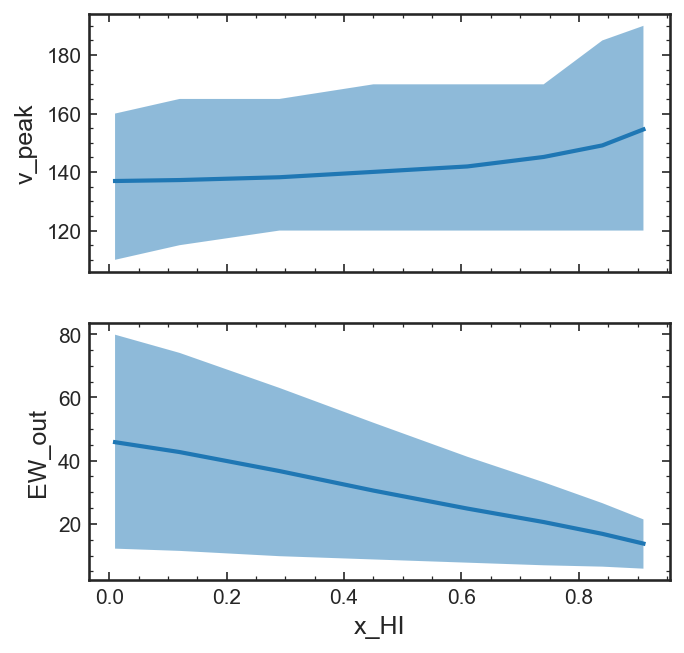

In [508]:
df_mean = vpeak_df.groupby('xHI', as_index=False).mean()
df_u = vpeak_df.groupby('xHI', as_index=False).quantile(.84)
df_l = vpeak_df.groupby('xHI', as_index=False).quantile(.16)

fig, ax = plt.subplots(2,1, sharex=True, figsize=(5,5), dpi=150)

ax[0].plot(df_mean['xHI'], df_mean['vpeak'])
ax[0].fill_between(df_mean['xHI'], df_l['vpeak'], df_u['vpeak'], alpha=0.5)

ax[1].plot(df_mean['xHI'], df_mean['EW_out'])
ax[1].fill_between(df_mean['xHI'], df_l['EW_out'], df_u['EW_out'], alpha=0.5)

ax[1].set_xlabel('x_HI')
ax[0].set_ylabel('v_peak')
ax[1].set_ylabel('EW_out')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_mean['xHI'], df_mean['vpeak'])
print(slope, intercept, r_value, p_value, std_err)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_mean['xHI'], df_mean['EW_out'])
print(slope, intercept, r_value, p_value, std_err)

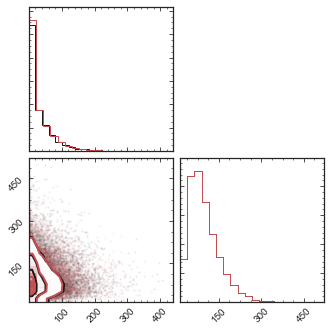

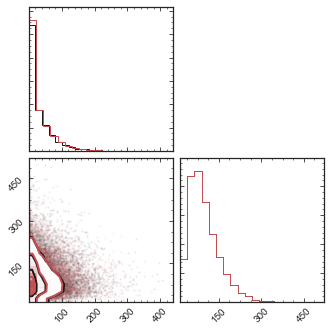

In [662]:
fig= corner.corner(np.vstack((EW_in_scatter, DV_in)).T, hist_kwargs={'lw':1}, hist2d_kwargs={'log':True})
corner.corner(np.vstack((EW_in, DV_in)).T, hist_kwargs={'lw':1}, hist2d_kwargs={'log':True}, color='r', fig=fig)